# Polynomial Ridge Regression

In [0]:
import numpy as np
from itertools import combinations_with_replacement
from sklearn.pipeline import Pipeline
from sklearn.exceptions import NotFittedError
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib as mpl

## Mathematical expression of the polynomial feature generating algorithm:
For one example $x^{(i)}$:

Main trick of polynomial regression - feature combination under predefined degree.
Let's define our $degree = 3$ and $x^{(i)} = (x_{1})$ - so that we have only one feature as in our current dataset for the sake of simplicity(later you will see generalized solution for any amount of features and any degree).

So, having $degree = 3$ and $x^{(i)} = (x^{(i)}_{1})$ we transform our feature vector to be:
$$x^{(i)} = ((x^{(i)}_{1})^0=1, x^{(i)}_{1}, (x^{(i)}_{1})^2, (x^{(i)}_{1})^3)$$

Having more than 1 features would cause combinations with replacements for each feature under each degree in range [0, $degree$].

After that step we have regular well known process, but in this lab we will use a little trick with bias variable.
You should already be familiar with it.

Main idea is to add 1 to each training example on the first position. It gives us an ability to count our bias inside of the weights vector on the first position too. So, now our $x^{(i)}$ will look like this:
$$x^{(i)} = (1, (x^{(i)}_{1})^0=1, x^{(i)}_{1}, (x^{(i)}_{1})^2, (x^{(i)}_{1})^3)$$
Let's create class PolynomialFeatures and init method transform inside which will transform our flat input features into features of higher degrees.
As example for degree=3 and features $(x_1, x_2, x_3)$ we will get:

$$((x_1, x_2, x_3),3) -> (1, x_1, x_2, x_3, x^2_1, x_1 x_2, x_1 x_3, x^2_2, x_2 x_3, x^2_3, x^3_1, x^2_1 x_2, x^2_1 x_3,  x_1 x^2_2, x_1 x_2 x_3, x_1 x^2_3, x^3_2, x^2_2 x_3, x_2 x^2_3, x^3_3)$$

In [0]:
class PolynomialFeatures:
    def __init__(self, degree=2, include_bias=True):
        self.degree = degree
        self.include_bias = include_bias

    def fit(self, X: np.ndarray, *args):
        # (1, 2) => [(1),(2),(1,1),(1,2),(2,2)]
        n_samples, n_features = X.shape
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, self.degree + 1)]
        # combs = [(),((1),(2)),((1,1),(1,2),(2,2))]
        flat_combs = [item for sublist in combs for item in sublist if item]
        # flat_combs = [(1),(2),(1,1),(1,2),(2,2)]
        self.combinations = flat_combs
        return self
        
    def transform(self, X: np.ndarray, *args) -> np.ndarray:
        """
        Transform data to polynomial features
        """
        n_samples, n_features = X.shape

        try:
            X_new = np.empty(shape=(n_samples, len(self.combinations)))
        except AttributeError:
            msg = "This %s instance is not fitted yet."
            raise NotFittedError(msg % self.__class__.__name__)
        else:
            for i in range(n_samples):
                for j, index_combs in enumerate(self.combinations):
                    X_new[i,j] =  np.prod(X[i, index_combs])
            if self.include_bias:
                return np.column_stack((np.ones(len(X_new)),X_new))
            return X_new
    
    def fit_transform(self, X: np.ndarray, *args):
        return self.fit(X).transform(X)

## Check Polynomial Features

In [0]:
a = np.array([[2,3],[4,5]])
print('Input table:')
print(a, end='\n\n')
feature_generator = PolynomialFeatures(degree=3, include_bias=True)
x = feature_generator.fit_transform(a)
print('Output table:')
print(x, end='\n\n')
print('Index combinations:\n', feature_generator.combinations)

Input table:
[[2 3]
 [4 5]]

Output table:
[[  1.   2.   3.   4.   6.   9.   8.  12.  18.  27.]
 [  1.   4.   5.  16.  20.  25.  64.  80. 100. 125.]]

Index combinations:
 [(0,), (1,), (0, 0), (0, 1), (1, 1), (0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 1, 1)]


## Polynomial Ridge Regression algorithm
**Mathematical expression of the algorithm**:
For one example $x^{(i)}$:

Main trick of polynomial regression - feature combination under predefined degree.
Let's define our $degree = 3$ and $x^{(i)} = (x_{1})$ - so that we have only one feature as in our current dataset for the sake of simplicity(later you will see generalized solution for any amount of features and any degree).

So, having $degree = 3$ and $x^{(i)} = (x^{(i)}_{1})$ we transform our feature vector to be:
$$x^{(i)} = ((x^{(i)}_{1})^0=1, x^{(i)}_{1}, (x^{(i)}_{1})^2, (x^{(i)}_{1})^3)$$

Having more than 1 features would cause combinations with replacements for each feature under each degree in range [0, $degree$].

After that step we have regular well known process, but in this lab we will use a little trick with bias variable.
You should already be familiar with it.

Main idea is to add 1 to each training example on the first position. It gives us an ability to count our bias inside of the weights vector on the first position too. So, now our $x^{(i)}$ will look like this:
$$x^{(i)} = (1, (x^{(i)}_{1})^0=1, x^{(i)}_{1}, (x^{(i)}_{1})^2, (x^{(i)}_{1})^3)$$

So, predictor function:
$$h^{(i)} =  w^T x^{(i)} \tag{1}$$

<b>Ridge</b> a.k.a <b>L2 Regularization</b>.
Having really high order polynomial function we can easily overfit on our training set.
The main technique to prevent overfitting called regularization.
You should already be familiar with theory of l2 regularization. Our cost function will look like this:

The cost is then computed by summing squared diff over all training examples:
$$J = \frac{1}{2}\sum_{i=1}^{m}(h^{(i)} - y^{(i)})^{2} + \frac{1}{2}\lambda ||w||^2_2\tag{2}$$

Where $\lambda$ is regularization term and $||w||_2$ is Euclidean norm.

Now, only gradient have to be defined.
$$X = (x^{(1)}, x^{(2)}, ..., x^{(m-1)}, x^{(m)})$$
$$H = w^T X = (h^{(1)}, h^{(2)}, ..., h^{(m-1)}, h^{(m)})$$

$$ \frac{\partial J}{\partial w} = X(H-Y)^T + \lambda w \tag{3}$$


In [0]:
def mean_squared_error(Y_pred: np.ndarray, Y_true: np.ndarray) -> float:
    return 1/len(Y_true) * ((Y_true - Y_pred)**2).sum()

class RidgeRegression:
    def __init__(self, alpha=.1, max_iters=500, learning_rate=.01,
                 validation=None, fit_intercept=False, print_loss=True,
                 print_per_n_iter=5, early_stoping=20, epsilon=10e-5):
        self.alpha = alpha
        self.max_iters = max_iters
        self.learning_rate = learning_rate
        self.loss_history = []
        self.coef_history = []
        self.fit_intercept = fit_intercept
        if validation is not None:
            self.validation = True
            self.val_loss_history = []
            self.val_X = self._add_intercept(validation[0])
            self.val_Y = validation[1]
        else:
            self.validation = False
        self.print_loss = print_loss
        self.print_per_n_iter = print_per_n_iter
        self.early_stoping = early_stoping
        self.epsilon = epsilon
        self.n_unchanged_steps = 0
    
    def _add_intercept(self, X):
        if self.fit_intercept:
            return np.column_stack((np.ones(len(X)), X))
        return X
    
    def _update(self, mse):
        self.coef_history.append(self.coef_.flatten())
        self.loss_history.append(mse)
        if self.validation is not None:
            test_mse = mean_squared_error(self.val_X.dot(self.coef_), self.val_Y)
            self.val_loss_history.append(test_mse)
            
    def _check_loss(self):
        if self.validation:
            if (abs(self.val_loss_history[-1] - self.val_loss_history[-2]) < self.epsilon) or \
            (self.val_loss_history[-1] - self.val_loss_history[-2] > 0):
                self.n_unchanged_steps += 1
                if self.n_unchanged_steps == self.early_stoping:
                    self.coef_ = self.coef_history[np.argmin(self.val_loss_history)]
                    return True
            else:
                self.n_unchanged_steps = 0
                return False
        else:
            if abs(self.loss_history[-1] - self.loss_history[-2]) < self.epsilon or \
            self.loss_history[-1] - self.loss_history[-2] > 0:
                self.n_unchanged_steps += 1
                if self.n_unchanged_steps == self.early_stoping:
                    return True
            else:
                self.n_unchanged_steps = 0
                return False
        
    def fit(self, X, Y):
        X_train = self._add_intercept(X)
        n_samples, n_features = X_train.shape
        Y_train = Y.reshape(n_samples, 1)
        
        # Initialize weights
        self.coef_ = np.zeros(shape=(n_features, 1), dtype=float)
        
        # Do gradient descent for max_iters
        for i in range(self.max_iters):
            
            if self.coef_.shape != (n_features, 1):
                self.coef_ = self.coef_.reshape(n_features, 1)
                
            # Calculate prediction
            H = np.matmul(X_train, self.coef_)
            
            # Gradient of l2 loss
            grad = np.matmul(X_train.T, (H - Y_train)) - self.coef_ * self.alpha
            
            # Update weights
            self.coef_ = self.coef_ - grad * self.learning_rate
            
            # Update history
            self._update(mean_squared_error(X_train.dot(self.coef_), Y_train))
            if self.print_loss and i % self.print_per_n_iter == 0:
                if self.validation:
                    print ("%4i epoch: train_mse - %10.3f, test_mse - %10.3f" %(i, self.loss_history[-1], self.val_loss_history[-1]))
                else:
                    print ("%4i epoch: train_mse - %10.3f" %(i, self.loss_history[-1]))
            if i >= 1 and self._check_loss():
                break
        return self
    
    def predict(self, X):
        X_pred = self._add_intercept(X)
        try:
            Y_pred = np.dot(X_pred, self.coef_)
        except AttributeError:
            msg = "This %s instance is not fitted yet."
            raise NotFittedError(msg % self.__class__.__name__)
        return Y_pred
        

In [0]:
# Loading the data
def load_data():
    data = np.genfromtxt('time_temp_2016.tsv', delimiter='\t')
    x = data[:, 0].reshape(-1,1)
    y = data[:, 1].reshape(-1,1)
    return train_test_split(x, y, test_size=0.25, random_state=42), x

(train_set_x, test_set_x, train_set_y, test_set_y), full_feature_set_for_plot = load_data()

In [0]:
print("Number of training examples: %3s" % len(train_set_x))
print("Number of testing examples:  %3s" % len(test_set_x), end='\n\n')

Number of training examples: 274
Number of testing examples:   92



### Data visualization
To familiarize oneself with the data obtained, we will plot the `Temperature` as a function of `Day`. Since our `Day` feature was already normalized to 0-1 range, we will multiply it by 366 to restore the correct day of the year. Let's also add different colors to train and test samples to make it fancy.

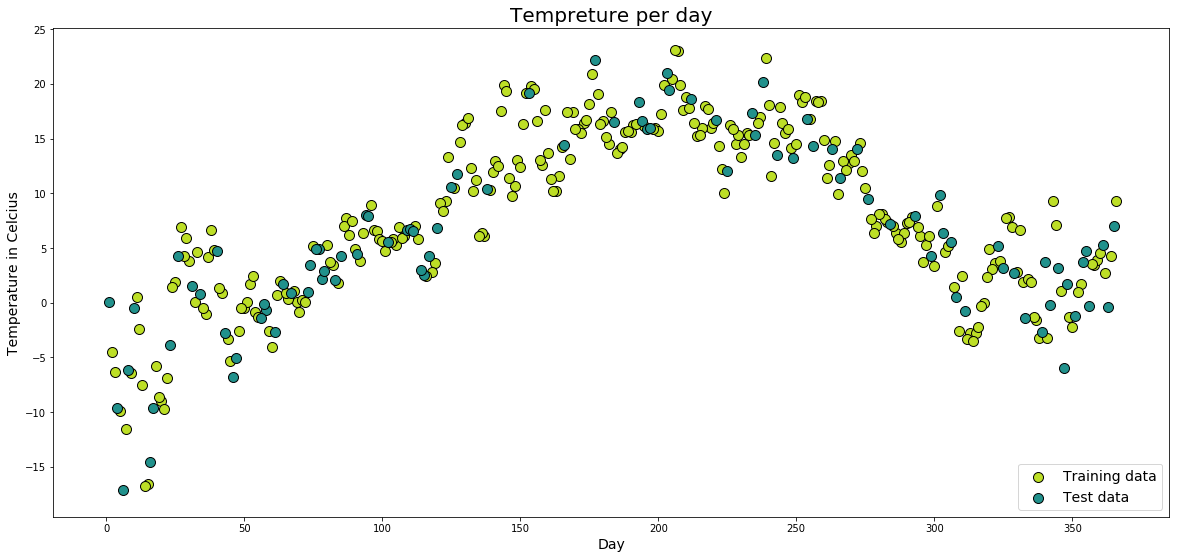

In [0]:
figure, axis = plt.subplots(figsize=(20,9))
cmap = plt.get_cmap('viridis')
m1 = plt.scatter(366 * train_set_x, train_set_y, edgecolor='black',
                 color=cmap(0.9), s=100, label="Training data")
m2 = plt.scatter(366 * test_set_x, test_set_y, edgecolor='black',
                 color=cmap(0.5), s=100, label="Test data")
plt.title('Tempreture per day', fontsize=20)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Temperature in Celcius', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.show()

In [0]:
polynomial_feature_generator = PolynomialFeatures(degree=20)
val_X = polynomial_feature_generator.fit_transform(test_set_x)
print(val_X.shape)

(92, 21)


In [0]:
polynomial_ridge_regression = Pipeline([
    ('polynomial feature generator', polynomial_feature_generator),
    ('regressor', RidgeRegression(alpha=0.1,
                                  max_iters=10000,
                                  learning_rate=.001,
                                  fit_intercept=False,
                                  print_per_n_iter=1000,
                                  validation=(val_X, test_set_y)))
])

In [0]:
polynomial_ridge_regression.fit(train_set_x, train_set_y)

   0 epoch: train_mse -     83.091, test_mse -     68.016
1000 epoch: train_mse -     13.064, test_mse -     13.523
2000 epoch: train_mse -     12.498, test_mse -     12.914
3000 epoch: train_mse -     12.179, test_mse -     12.555
4000 epoch: train_mse -     11.979, test_mse -     12.332


Pipeline(memory=None,
     steps=[('polynomial feature generator', <__main__.PolynomialFeatures object at 0x7f66aac8fcf8>), ('regressor', <__main__.RidgeRegression object at 0x7f6691758e80>)])

# Result visualization

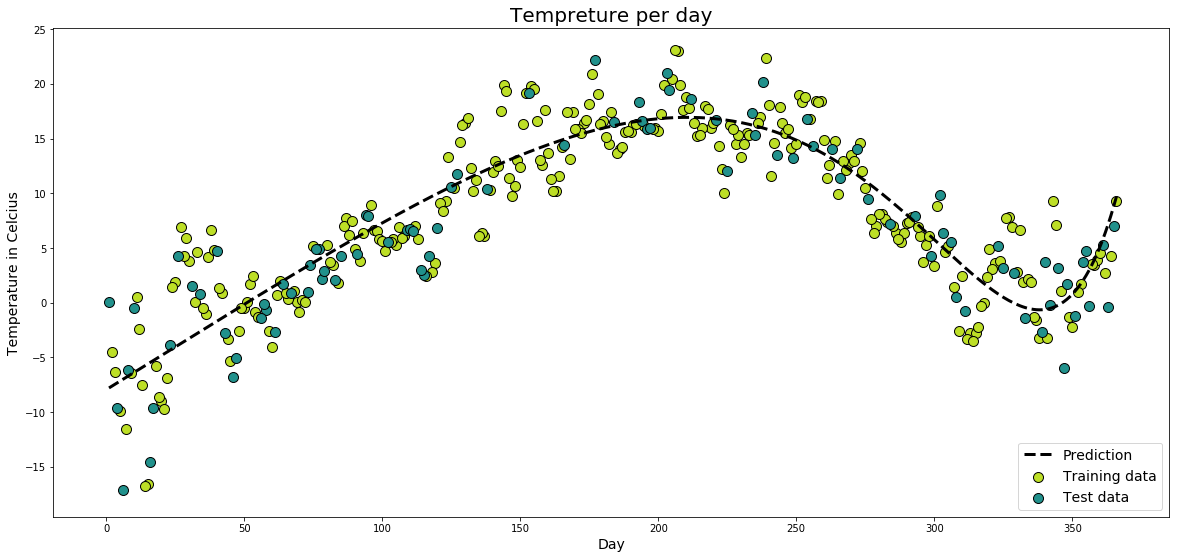

In [0]:
y_val = polynomial_ridge_regression.predict(full_feature_set_for_plot)
figure, axis = plt.subplots(figsize=(20,9))
cmap = plt.get_cmap('viridis')
m1 = plt.scatter(366 * train_set_x, train_set_y, edgecolor='black',
                 color=cmap(0.9), s=100, label="Training data")
m2 = plt.scatter(366 * test_set_x, test_set_y, edgecolor='black',
                 color=cmap(0.5), s=100, label="Test data")
plt.plot(366 * full_feature_set_for_plot, y_val, linestyle='--', color='black', linewidth=3, label="Prediction")
plt.title('Tempreture per day', fontsize=20)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Temperature in Celcius', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.show()

In [0]:
def plot_loss(regressor, axis):
    cmap = plt.get_cmap('viridis')
    loss = regressor.loss_history
    axis.plot(loss, color=cmap(0.9), linewidth=3,
              label=f'Train loss ({regressor.loss_history[-1]:.3f})')
    try:
        val_loss = regressor.val_loss_history
    except AttributeError:
        pass
    else:
        axis.plot(val_loss, color=cmap(0.5), linewidth=3,
                  label=f'Test loss ({regressor.val_loss_history[-1]:.3f})')
    axis.set_title('Loss function', fontsize=18)
    axis.set_xlabel('Epochs', fontsize=14)
    axis.legend(fontsize=14)
    
def plot_weigth(weight_history, axis, feature_names=None, legend=True):
    weight_history = np.array(weight_history)
    if feature_names:
        labels = ['bias'] + feature_names 
    else:
        labels = ['bias'] + [f'feature {i}' for i in range(weight_history.shape[1] - 1)]
    
    for i, weight in enumerate(weight_history.T):
        color = np.random.uniform(size=3)
        axis.plot(weight_history[:, i], color=color, linewidth=3,
                  label=f'{labels[i]} ({weight_history[-1,i]:.2f})')
    axis.set_title('Weight History', fontsize=18)
    axis.set_xlabel('Epochs', fontsize=14)
    if legend:
        axis.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))

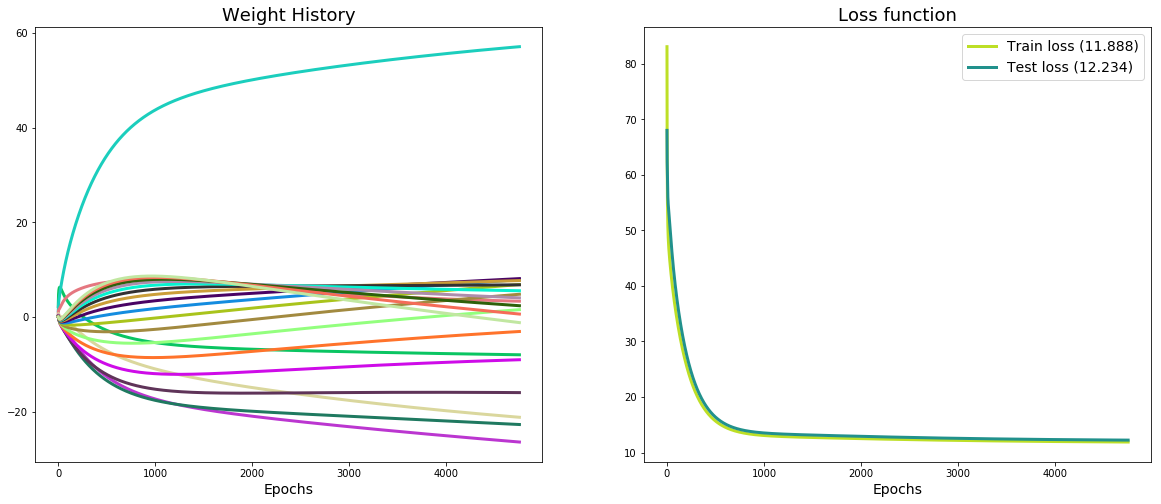

In [0]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
plot_weigth(polynomial_ridge_regression.named_steps.regressor.coef_history,
            axis[0], legend=False)
plot_loss(polynomial_ridge_regression.named_steps.regressor, axis[1])